In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from brian2 import start_scope, prefs, run
from brian2 import PoissonGroup, NeuronGroup, Synapses, StateMonitor, SpikeMonitor, TimedArray
from brian2 import ms, mV, Hz

# Import libraries from outside folder
import sys
sys.path.append('../lib/')

import traces_lib, opencv_lib

/home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


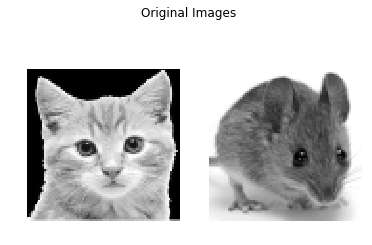

In [2]:
# Load raw images
# img1 = (mpimg.imread('img/cat4.png')[:,:,0] > 0.5).astype(int)
# img2 = (mpimg.imread('img/mouse4.png')[:,:,0] > 0.5).astype(int)
img1 = mpimg.imread('../img/cat4.png')
img2 = mpimg.imread('../img/mouse4.png')

# Plot raw images
fig, axis = plt.subplots(ncols=2)
axis[0].imshow(img1, cmap='gray')
axis[1].imshow(img2, cmap='gray')
axis[0].set_axis_off()
axis[1].set_axis_off()
plt.suptitle('Original Images')
plt.show()

## Solution 2 (Good solution)

Plasticity of the spiking threshold: Increase threshold by fixed amout at every spike, and use homeostatic decay to restore it to resting threshold. This way, neurons that fire more should have higher threshold, which would in turn decrease their firing rate.

<table><tr><td>
    $\begin{eqnarray}
      \dot{V}(t) &=& \frac{V_0 - V}{\tau_V} + \dot{V}_{\mathrm{inp}}(t) - T(t)S(t) \\
      \dot{T}(t) &=& \eta_T(S(t) - R_0)
    \end{eqnarray}$
</td></tr></table>

where the spike function is given by
<table><tr><td>
    $S(t) = \sum_i \delta(t - t_i)$
</td></tr></table>
and the input is given by Poisson distribution
<table><tr><td>
    $\dot{V}_{\mathrm{inp}}(t) = \Delta V \cdot P(f_0 + f_{\mathrm{inp}} \mathrm{PIX}_{\mathrm{inp}})$
</td></tr></table>

In [10]:
%%time
start_scope()
prefs.codegen.target = "numpy"

#######################################
# Neuron constants
#######################################

OUTPUT_SAMPLING_TIMESCALE = 1*ms

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 1000*ms

LIF_V_TAU = 10*ms
LIF_V_0 = 0.0*mV

LIF_R_AVG = 10.0*Hz  # Resting state rate
LIF_T_AVG = 50*mV    # Initial expected threshold
LIF_T_ETA = 2*mV     # LIF change

#######################################
# Input constants
#######################################

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_SPIKES_PER_THRESHOLD = 3
INPUT_DV_PER_SPIKE = LIF_T_AVG / INPUT_SPIKES_PER_THRESHOLD
INPUT_FREQ_0   = 100 * Hz
INPUT_FREQ_STIM = 300 * Hz
INPUT_FREQ_AVG = INPUT_FREQ_0 + INPUT_FREQ_STIM / 2
print("Input Frequencies are", INPUT_FREQ_0, "+/-", INPUT_FREQ_STIM)
print("Typical threshold is", LIF_T_AVG, ", voltage increase per spike is", INPUT_DV_PER_SPIKE)

#######################################
# Neuron Equations
#######################################

# Membrane potential V and threshold T both return back to resting values over time
eqs_neu = '''
dv/dt = (LIF_V_0 - v) / LIF_V_TAU : volt
dT/dt = -LIF_T_ETA * LIF_R_AVG    : volt
'''

# On spike, the threshold is increased
reset = '''
v = LIF_V_0
T += LIF_T_ETA
'''

# Connect Input and LIF one-to-one
G_INP = PoissonGroup(N_NEURON, INPUT_FREQ_0 + INPUT_FREQ_STIM * np.ndarray.flatten(img1))
G_LIF = NeuronGroup(N_NEURON, eqs_neu, threshold='v > T', reset=reset)#, method='exact')
S = Synapses(G_INP, G_LIF, on_pre='v_post += INPUT_DV_PER_SPIKE')
S.connect(j='i')

# Monitor the value of one neuron somewhere in the middle of the image
M = StateMonitor(G_LIF, 'T', record=True, dt=OUTPUT_SAMPLING_TIMESCALE)
spikemon_inp = SpikeMonitor(G_INP)
spikemon_lif = SpikeMonitor(G_LIF)

run(RUN_TIME)

WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    "i" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 999. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.00s, trying other methods too

Number of neurons is 6400
Input Frequencies are 100. Hz +/- 300. Hz
Typical threshold is 50. mV , voltage increase per spike is 16.66666667 mV
CPU times: user 2.53 s, sys: 38.5 ms, total: 2.57 s
Wall time: 2.57 s


Started writing video rez/test1_lif_sol2_inp.avi of 1000 frames using time step 0.001
Started writing video rez/test1_lif_sol2_lif.avi of 1000 frames using time step 0.001
Average LIF firing rate is 45.0478125 Hz
Min threshold after training is 0.028000000000012723
Max threshold after training is 0.10399999999998238
Average threshold after training is 0.0700956249999851


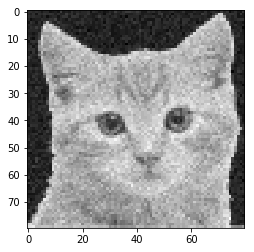

In [12]:
#######################################
# Write videos
#######################################

traces_lib.spikes2rateVideo(
    'rez/test1_lif_sol2_inp.avi',
    img1.shape,
    np.array(spikemon_inp.i),
    np.array(spikemon_inp.t),
    0,
    float(RUN_TIME),
    1000,
    0.1,
    maxRate=int(INPUT_FREQ_0+INPUT_FREQ_STIM))

traces_lib.spikes2rateVideo(
    'rez/test1_lif_sol2_lif.avi',
    img1.shape,
    np.array(spikemon_lif.i),
    np.array(spikemon_lif.t),
    0,
    float(RUN_TIME),
    1000,
    0.05,
    maxRate=150)


# Threshold trace
MaxThreshold = np.max(np.array(G_LIF.T))
traceT = (np.array(M.T) * 255 / MaxThreshold).astype(int)
with opencv_lib.cvWriter('rez/test1_lif_sol2_T.avi', img1.shape, codec='MJPG') as vid:
    for i in range(traceT.shape[1]):
        vid.write(traceT[:,i].reshape(img1.shape))

#Plot resulting threshold values
print("Average LIF firing rate is", len(spikemon_lif.i) / N_NEURON / RUN_TIME)
print("Min threshold after training is", np.min(np.array(G_LIF.T)))
print("Max threshold after training is", np.max(np.array(G_LIF.T)))
print("Average threshold after training is", np.average(np.array(G_LIF.T)))
plt.figure()
plt.imshow(np.array(G_LIF.T).reshape(img1.shape), cmap='gray')
plt.show()